# Example training notebook.

https://registry.opendata.aws/elp-nouabale-landscape/


In [1]:
import os
if os.environ.get('COLAB_RELEASE_TAG'):
  if not os.path.exists("data"):
    from google.colab import drive
    drive.mount('/content/drive')
    os.symlink('/content/drive/MyDrive/AI for Forest Elephants 2 Shared/01. Data/cornell_data', "./data")
  %pip install --quiet torchshow
  %pip install --quiet torchlens
  %pip install --quiet einops
  %pip install --quiet umap-learn

In [2]:
import csv
import duckdb
import einops
import gc
import glob
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import re
import scipy.signal as signal
import soundfile as sf
import time
import torch
import torchaudio
import torchaudio.io as tai
import torchaudio.functional as taf
import torchaudio.transforms as tat
import torchlens as tl
import tqdm
import umap
from sklearn.utils.class_weight import compute_class_weight
from dataclasses import dataclass
from scipy import signal
from scipy.signal import butter, lfilter, freqz
from torchaudio.io import StreamReader

pd.set_option('display.max_rows', 100)  # or a larger number, as needed
pd.set_option('display.max_columns', 100)  # or a larger number, as needed
pd.set_option('display.max_colwidth', 200)  # or a larger number, as needed
pd.set_option('display.width', 1024)  # or a larger number, as needed

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"using {DEVICE}")

# Arnaud's trick of upshifting the rumbles to human hearing range...
# ... but taken a step further.   The pretrained models work **great**
# on high-pitched birds, 
#
# Fairseq defauls to assuming 16Khz audio
# https://github.com/facebookresearch/fairseq/issues/1280
#
# By picking a lowSR like 1000, (16000 / 1000 = 16) that's like upshifting by 4 octaves. (humans)
# By picking an extreme SR like 250, (16000 / 250 = 64) that's like upshifting by 6 octaves. (small birds)

AVES_SR = 250 * 2
EXPERIMENT_NAME = 'with_normalization' # rumble classifier 3
DEFAULT_SR = None
N_FFT = None
DEBUG = True

os.makedirs('tmp/aves',exist_ok=True)
print(torch.__version__, torchaudio.__version__,  torch.cuda.is_available())

using cuda
2.3.1+cu121 2.3.1+cu121 True


In [3]:
import elephant_rumble_inference as eri

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

aves_hubert_model = eri.AvesTorchaudioWrapper().to(DEVICE)
elephant_rumble_classifier = eri.ElephantRumbleClassifier().to('cpu')
aves_hubert_model.eval() # only train our layers - give up on fine-tuning AVES

raven_file_helper     = eri.RavenFileHelper("./data/Rumble")
audio_file_visualizer = eri.AudioFileVisualizer()
audio_file_processor  = eri.AudioFileProcessor(aves_hubert_model,elephant_rumble_classifier,device=DEVICE)


### Visualize this model

In [4]:
if visualize_model := False:
  model_history = tl.log_forward_pass(aves_hubert_model, torch.rand(1, 1000), layers_to_save='all', vis_opt='rolled')
  print(model_history)


  visualizations saved to /tmp/1.png at 1.282426357269287


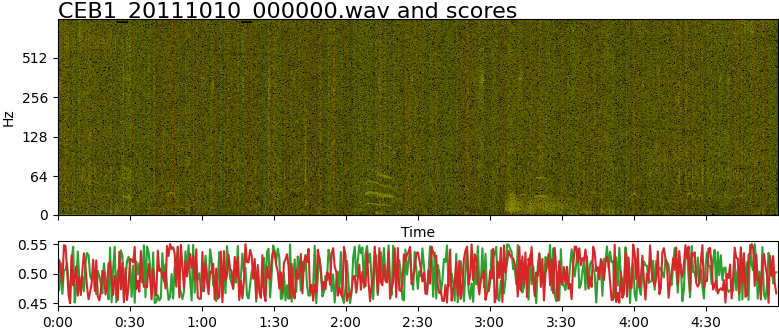

In [40]:

########################################
###Testing
########################################
if DEBUG:
    audio_file = 'CEB1_20111010_000000.wav'
    start_time = 0
    duration = 60 * 60
    audio_path = raven_file_helper.audio_filename_to_path[audio_file]
    y = raven_file_helper.get_downsampled_tensor(audio_file,start_time,duration+start_time,new_sr=AVES_SR)
    audio_file_visualizer.visualize_audio_file_fragment(
        f"{audio_file} and scores",
        '/tmp/1.png',
        audio_path,
        torch.rand(y.shape[0]) * 0.1 + 0.45,
        torch.rand(y.shape[0]) * 0.1 + 0.45,
        audio_file_processor,
        start_time=0,
        end_time=60*5,
        colormap='raw',
        width=8,
        height=3.5
    )
    from PIL import Image
    ipd.display(Image.open('/tmp/1.png'))
########################################
# good so far
########################################


In [6]:
def get_aves_embeddings(y):
    with torch.inference_mode(): # torch.no_grad():
      y32 = y.to(torch.float32).view(1,y.shape[0])
      aves_embeddings = aves_hubert_model.forward(y32.to(DEVICE)).to('cpu').detach()
      del(y32)
      reshaped_tensor = einops.rearrange(aves_embeddings, '1 n d -> n d')  # remove that batch dimension
      del(aves_embeddings)
      if torch.cuda.is_available():
        torch.cuda.empty_cache()
      return reshaped_tensor.to('cpu').detach()

if DEBUG:
  ae = get_aves_embeddings(y)


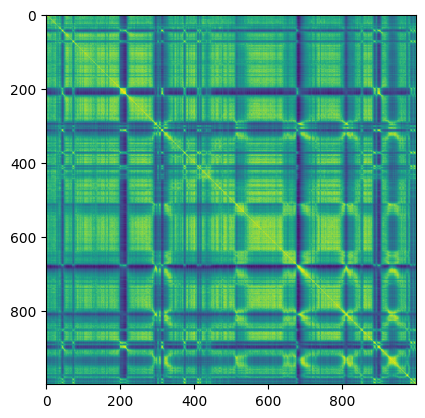

In [7]:
def get_normalized_aves_embeddings(y):
    with torch.inference_mode(): # torch.no_grad():
      embs = get_aves_embeddings(y)
      norms = embs.norm(p=2, dim=1, keepdim=True)
      unit_vecs = embs / norms
      return unit_vecs.to('cpu').detach()

if DEBUG:
  nae = get_normalized_aves_embeddings(y)
  plt.imshow((nae @ nae.T)[0:1000,0:1000])
  plt.show()


In [8]:
def get_aves_embedding_cache_filename(audio_file,start,duration,preroll,postroll,sr):
   prefix = f"tmp/aves_embedding_cache/{sr}-{preroll}-{postroll}/{audio_file}"
   filename = f"{prefix}/{start}-{duration}.pt"
   os.makedirs(prefix,exist_ok=True)
   return filename

def get_aves_embeddings_from_file_with_buffers(audio_file,start,duration,preroll,postroll,sr=AVES_SR):
    cachefile = get_aves_embedding_cache_filename(audio_file,start,duration,preroll,postroll,sr)
    if os.path.exists(cachefile):
        return torch.load(cachefile,mmap=True)#.to('cpu').detach()
    if preroll > start:
        preroll = start
    y = raven_file_helper.get_downsampled_tensor(audio_file,start-preroll,duration+preroll+postroll,new_sr=sr)
    unit_vecs = get_normalized_aves_embeddings(y)#.to('cpu').detach()
    preroll_index = int(audio_file_processor.time_to_score_index(preroll))
    postroll_index = int(audio_file_processor.time_to_score_index(preroll+duration))
    # .clone().detatch() to avoid saving the entire original vector
    relevant_unit_vecs = unit_vecs[preroll_index:postroll_index].clone().detach()
    torch.save(relevant_unit_vecs,cachefile)
    return relevant_unit_vecs


def get_interesting_embeddings(audio_file,labels,max_labels=9999,sr=AVES_SR):
    interesting_embs = []
    labels = labels[:max_labels]
    with tqdm.tqdm(total=len(labels)) as pbar:
        for idx,row in enumerate(labels):
            unit_vecs = get_aves_embeddings_from_file_with_buffers(audio_file,row.bt,row.duration,500,200,sr)
            if mean_embedding_per_label := False:
                mean_tensor = einops.reduce(unit_vecs, 'h w -> w', 'mean')
                mean_tensor = mean_tensor / mean_tensor.norm(p=2)
                interesting_embs.append(mean_tensor.unsqueeze(0))
            elif trim_labels := False:
                # Idea - Trim training data bounding boxes that extend beyond the actual rumble
                interesting_embs.append(unit_vecs[3:-3])
            else:
                interesting_embs.append(unit_vecs)
            if idx >= max_labels:
                break
            #del(y,unit_vecs,mean_tensor)
            pbar.update(1)
        return torch.concat(interesting_embs)
    
if DEBUG:
    audio_file = 'CEB1_20111010_000000.wav'
    labels = raven_file_helper.get_all_labels_for_wav_file(audio_file)
    interesting_embs = get_interesting_embeddings(audio_file,labels,max_labels=30)
    print((interesting_embs @ interesting_embs.T)[0:5,0:5])




100%|██████████| 30/30 [00:00<00:00, 503.64it/s]

tensor([[1.0000, 0.7040, 0.6740, 0.7029, 0.7027],
        [0.7040, 1.0000, 0.9565, 0.8990, 0.8809],
        [0.6740, 0.9565, 1.0000, 0.9449, 0.9138],
        [0.7029, 0.8990, 0.9449, 1.0000, 0.9516],
        [0.7027, 0.8809, 0.9138, 0.9516, 1.0000]])


## 

In [9]:

def get_embeddings_for_labels_in_file(audio_file):
    gc.collect()
    labels = raven_file_helper.get_all_labels_for_wav_file(audio_file)
    if len(labels) < 2:
        return (None,None)
    negative_labels = raven_file_helper.get_negative_labels(labels)
    if len(negative_labels) < 2:
        return (None,None)
    print(f"found {len(labels)} labels and {len(negative_labels)} negative labels in {audio_file}")
    interesting_embs = get_interesting_embeddings(audio_file,labels,9999,sr=AVES_SR)
    uninteresting_embs = get_interesting_embeddings(audio_file,negative_labels,9999,sr=AVES_SR)
    return interesting_embs, uninteresting_embs

if DEBUG:
    ie,ue = get_embeddings_for_labels_in_file('CEB1_20111010_000000.wav')
    print(ie.shape,ue.shape,ie[0:3,0:3],ue[0:3,0:3])

found 467 labels and 319 negative labels in CEB1_20111010_000000.wav


100%|██████████| 319/319 [00:05<00:00, 63.26it/s] 

torch.Size([3140, 768]) torch.Size([26440, 768]) tensor([[-0.0020, -0.0129, -0.0109],
        [-0.0126,  0.0046,  0.0090],
        [-0.0095,  0.0040,  0.0095]]) tensor([[ 0.0078, -0.0220, -0.0023],
        [ 0.0056, -0.0037, -0.0091],
        [-0.0014,  0.0070, -0.0062]])


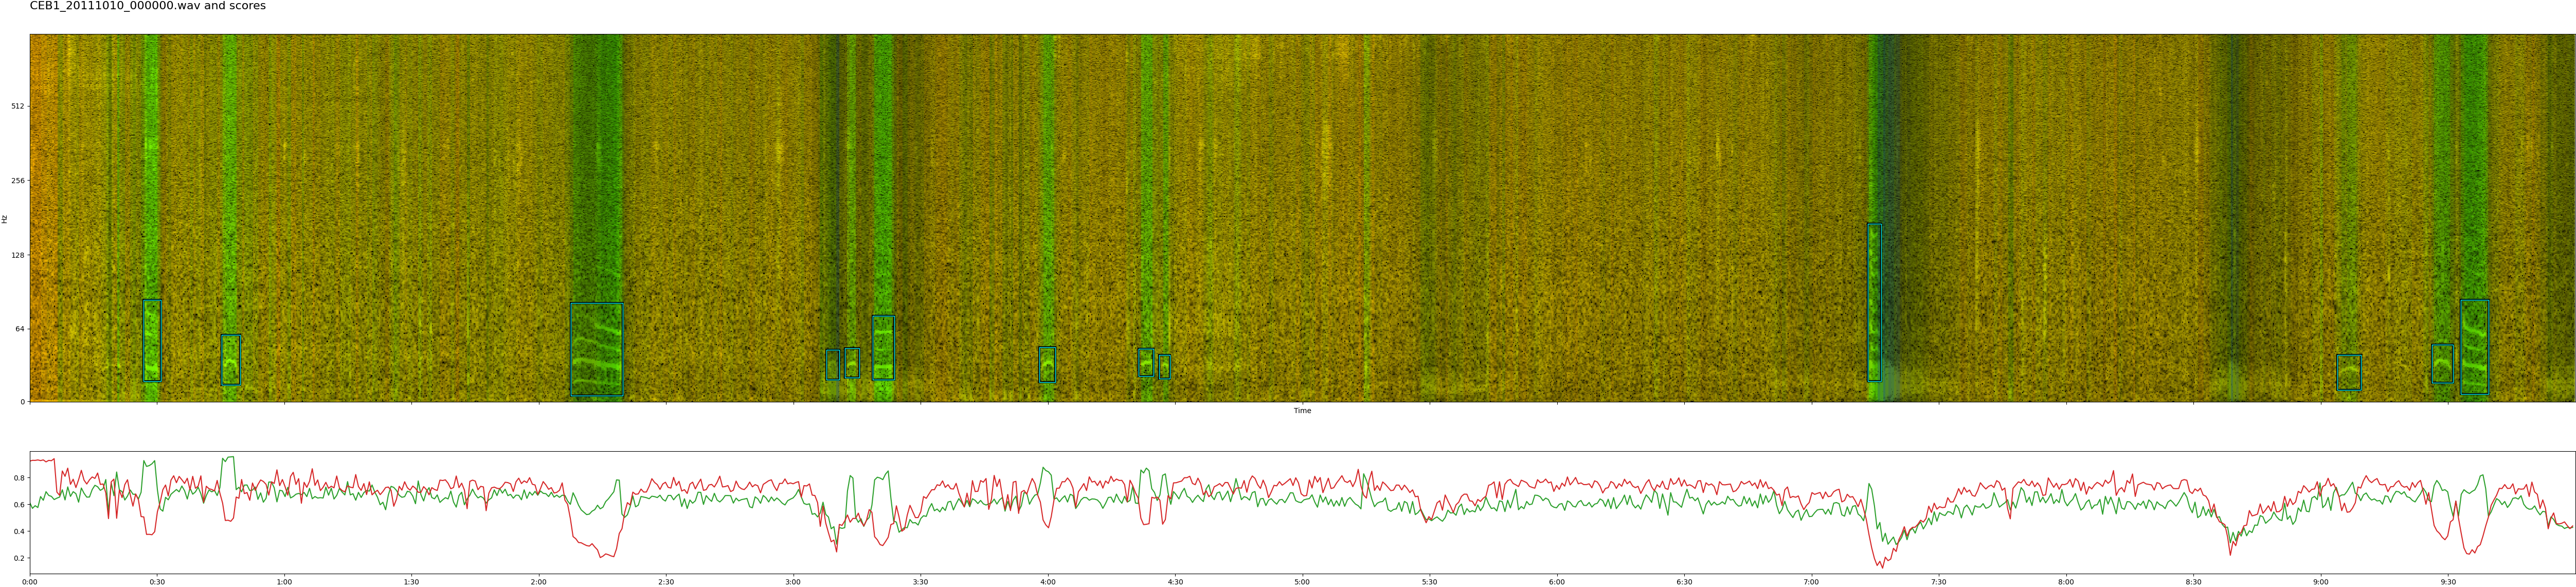

first interesting hour is at 0.0
  visualizations saved to /tmp/2.png at 2.403013229370117


In [10]:

def visualize_naive_aves_base_model_on_file(audio_file,interesting_embs,uninteresting_embs):
    labels = raven_file_helper.get_all_labels_for_wav_file(audio_file)
    if len(labels) < 2:
        return
    if interesting_embs is None or uninteresting_embs is None:
        print("all labels were too short?")
        return
    first_interesting_hour = labels[0].bt//60//60
    if first_interesting_hour > 24:
        print("Debug this out of memory error later")
        return
    print(f"first interesting hour is at {first_interesting_hour}")
    start_time = first_interesting_hour*60*60
    duration = 60 * 5

    first_hour_embs = get_aves_embeddings_from_file_with_buffers(audio_file,start_time, duration,100,30,sr=AVES_SR).to('cpu')

    multi_similarity = first_hour_embs @ interesting_embs.T
    multi_dissimilarity = first_hour_embs @ uninteresting_embs.T

    similarity = einops.reduce(multi_similarity, 'h w -> h', 'max')
    dissimilarity = einops.reduce(multi_dissimilarity, 'h w -> h', 'max')

    #visualization_helper.visualize_similarity_on_spectrogams(
    ##    audio_file, start_time,duration,similarity,
    #    dissimilarity,sr=500,n_fft=512,modelname="AVES_base_model")
    
    audio_file_visualizer.visualize_audio_file_fragment(
        f"{audio_file} and scores",
        '/tmp/2.png',
        audio_path,
        similarity,
        dissimilarity,
        audio_file_processor,
        start_time=0,
        end_time=60*5,
        colormap='raw',
        width=8,
        height=3.5,
        labels = labels
    )
from PIL import Image
ipd.display(Image.open('/tmp/2.png'))
if DEBUG:
    visualize_naive_aves_base_model_on_file(audio_file,ie[0:10],ue[0:10])
    


## Datasset and DataLoader helper methods

In [11]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
  def __init__(self, inputs, labels):
    self.inputs = inputs
    self.labels = torch.tensor([1 if l == 'rumble' else 0 for l in labels]) # convert labels to binary
    self.len = self.labels.shape[0]

  def __getitem__(self, index):
    return self.inputs[index].type(torch.float32), self.labels[index]

  def __len__(self):
    return self.len
  
  def save(self,name):
     torch.save((self.inputs,self.labels), f'mydataset_{name}.pt')

  def load(self,name):
    self.inputs,self.labels = torch.load(f'mydataset_{name}.pt')
    self.len = self.labels.shape[0]
  
def make_dataset(interesting_files, balance_classes=True):
  iea=[]
  uea=[]
  for f in interesting_files:
      ie,ue = get_embeddings_for_labels_in_file(f)
      if ie is not None and ue is not None:
          iea.append(ie)
          uea.append(ue)
  interesting_embs= torch.cat(iea)
  uninteresting_embs = torch.cat(uea)
  del(iea)
  del(uea)
  gc.collect()
  if balance_classes:
      # should probably be true - it worked really well with it true
      print("initially, the shapes were",interesting_embs.shape,uninteresting_embs.shape)
      print("or a ratio of",uninteresting_embs.shape[0] / interesting_embs.shape[0])
      num_rows_to_keep = interesting_embs.shape[0]
      random_indices = torch.randperm(uninteresting_embs.shape[0])[:num_rows_to_keep]
      uninteresting_embs = uninteresting_embs[random_indices]
  print(f"from {len(interesting_files)} found {interesting_embs.shape} positive and {uninteresting_embs.shape} negatives")
  all_embs = torch.cat((interesting_embs, uninteresting_embs), dim=0)
  all_labels = np.concatenate((np.array(['rumble'] * interesting_embs.shape[0]), 
                                np.array(['not'] * uninteresting_embs.shape[0])))
  return MyDataset(all_embs, all_labels)

# def split_dataset(a_dataset):
#   train_ds,test_ds,val_ds = torch.utils.data.random_split(
#         a_dataset,
#           [0.8, 0.1, 0.1], 
#         generator=torch.Generator().manual_seed(42)
#   )
#   return train_ds,test_ds,val_ds

# def get_dataloaders(a_dataset):
#   train_ds,test_ds,val_ds = split_dataset(a_dataset)
#   print(len(a_dataset),len(train_ds),len(test_ds),len(val_ds))
#   batch_size = 64
#   train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
#   test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=0)
#   val_loader  = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=0)
#   return train_loader,test_loader,val_loader



## Create a Training torch dataset with both Rumbles and non-rumbles

In [12]:
EXPERIMENT_NAME = 'sklearn.compute_class_weight'

In [13]:
if rebuild_training_dataset := True:
    training_files = raven_file_helper.get_files_from_train_folder()
    print(training_files[0:3],"...")
    training_dataset = make_dataset(training_files,balance_classes=True)
    training_dataset_name = 'from_train_folder'
    training_dataset.save('training_dataset')
else:
    print("loading saved dataset")
    training_dataset = MyDataset(torch.empty(1),torch.empty(1))
    training_dataset.load('training_dataset')


['nn01a_20180305_000000.wav', 'CEB1_20120728_000000.wav', 'nn01c_20180625_000000.wav'] ...
found 47 labels and 43 negative labels in nn01a_20180305_000000.wav


100%|██████████| 43/43 [00:00<00:00, 103.57it/s]


found 320 labels and 266 negative labels in CEB1_20120728_000000.wav


100%|██████████| 266/266 [00:04<00:00, 53.55it/s] 


found 18 labels and 20 negative labels in nn01c_20180625_000000.wav


100%|██████████| 20/20 [00:00<00:00, 78.26it/s] 


found 103 labels and 106 negative labels in CEB1_20120801_000000.wav


100%|██████████| 106/106 [00:00<00:00, 117.30it/s]


found 4 labels and 5 negative labels in jobo_20160623_000000.wav


100%|██████████| 5/5 [00:00<00:00, 130.73it/s]


found 4 labels and 6 negative labels in nn01b_20180220_000000.wav


100%|██████████| 6/6 [00:00<00:00, 93.07it/s]


found 7 labels and 9 negative labels in nn06e_20181115_000000.wav


100%|██████████| 9/9 [00:00<00:00, 90.76it/s]


found 225 labels and 162 negative labels in ceb1_20110123_000000.wav


100%|██████████| 162/162 [00:01<00:00, 83.48it/s]


found 9 labels and 7 negative labels in nn01a_20180126_000000.wav


100%|██████████| 7/7 [00:00<00:00, 154.49it/s]


found 18 labels and 29 negative labels in nn05a_20180531_000000.wav


100%|██████████| 29/29 [00:00<00:00, 145.22it/s]


found 8 labels and 8 negative labels in nn05a_20181110_000000.wav


100%|██████████| 8/8 [00:00<00:00, 71.76it/s]


found 222 labels and 131 negative labels in madj_20141227_000000.wav


100%|██████████| 131/131 [00:01<00:00, 75.38it/s]


found 20 labels and 23 negative labels in nn03d_20180817_000000.wav


100%|██████████| 23/23 [00:00<00:00, 96.49it/s] 


found 14 labels and 11 negative labels in nn05b_20180617_000000.wav


100%|██████████| 11/11 [00:00<00:00, 50.80it/s]


found 117 labels and 112 negative labels in CEB1_20120717_000000.wav


100%|██████████| 112/112 [00:01<00:00, 76.00it/s]


found 2 labels and 3 negative labels in nn05a_20180606_000000.wav


100%|██████████| 3/3 [00:00<00:00, 61.81it/s]


found 94 labels and 86 negative labels in madj_20150202_000000.wav


100%|██████████| 86/86 [00:00<00:00, 86.90it/s] 


found 164 labels and 88 negative labels in nn06a_20180716_000000.wav


100%|██████████| 88/88 [00:00<00:00, 104.09it/s]


found 230 labels and 193 negative labels in ceb1_20110103_000000.wav


100%|██████████| 193/193 [00:01<00:00, 184.74it/s]


found 47 labels and 52 negative labels in nn01f_20180709_000000.wav


100%|██████████| 52/52 [00:00<00:00, 108.21it/s]


found 11 labels and 18 negative labels in nn03d_20180916_000000.wav


100%|██████████| 18/18 [00:00<00:00, 97.06it/s] 


found 976 labels and 399 negative labels in madj_20150109_000000.wav


100%|██████████| 399/399 [00:07<00:00, 56.50it/s] 


found 28 labels and 20 negative labels in nn10b_20180728_000000.wav


100%|██████████| 20/20 [00:00<00:00, 111.34it/s]


found 5 labels and 4 negative labels in nn04c_20181017_000000.wav


100%|██████████| 4/4 [00:00<00:00, 61.45it/s]


found 64 labels and 59 negative labels in CEB1_20120811_000000.wav


100%|██████████| 59/59 [00:00<00:00, 129.15it/s]


found 68 labels and 69 negative labels in madj_20150206_000000.wav


100%|██████████| 69/69 [00:00<00:00, 124.24it/s]


found 27 labels and 26 negative labels in nn05d_20181118_000000.wav


100%|██████████| 26/26 [00:00<00:00, 146.77it/s]


found 115 labels and 28 negative labels in nn10a_20180702_000000.wav


100%|██████████| 28/28 [00:00<00:00, 68.95it/s]


found 34 labels and 41 negative labels in nn07b_20180923_000000.wav


100%|██████████| 41/41 [00:00<00:00, 78.99it/s]


found 8 labels and 6 negative labels in nn01a_20180706_000000.wav


100%|██████████| 6/6 [00:00<00:00, 230.92it/s]


found 55 labels and 37 negative labels in nn02d_20180608_000000.wav


100%|██████████| 37/37 [00:00<00:00, 102.73it/s]


found 47 labels and 31 negative labels in nn01e_20180620_100134.wav


100%|██████████| 31/31 [00:00<00:00, 158.96it/s]


found 48 labels and 16 negative labels in nn10b_20180604_000000.wav


100%|██████████| 16/16 [00:00<00:00, 91.95it/s]


found 289 labels and 208 negative labels in jobo_20160530_000000.wav


100%|██████████| 208/208 [00:01<00:00, 105.99it/s]


found 48 labels and 37 negative labels in nn06b_20180411_000000.wav


100%|██████████| 37/37 [00:00<00:00, 86.44it/s] 


found 42 labels and 32 negative labels in nn06a_20181101_000000.wav


100%|██████████| 32/32 [00:00<00:00, 74.40it/s] 


found 4 labels and 5 negative labels in nn01c_20180302_000000.wav


100%|██████████| 5/5 [00:00<00:00, 99.73it/s]


found 123 labels and 157 negative labels in CEB1_20120715_000000.wav


100%|██████████| 157/157 [00:01<00:00, 133.30it/s]


found 48 labels and 35 negative labels in nn04a_20180608_000000.wav


100%|██████████| 35/35 [00:00<00:00, 112.42it/s]


found 67 labels and 45 negative labels in nn06a_20180615_000000.wav


100%|██████████| 45/45 [00:00<00:00, 82.18it/s]


found 22 labels and 25 negative labels in nn05a_20190218_000000.wav


100%|██████████| 25/25 [00:00<00:00, 89.92it/s]


found 30 labels and 19 negative labels in nn02b_20180508_000000.wav


100%|██████████| 19/19 [00:00<00:00, 104.74it/s]


found 122 labels and 130 negative labels in CEB1_20120727_000000.wav


100%|██████████| 130/130 [00:01<00:00, 85.78it/s] 


found 241 labels and 150 negative labels in madj_20141223_000000.wav


100%|██████████| 150/150 [00:01<00:00, 141.59it/s]


found 92 labels and 97 negative labels in madj_20160425_000000.wav


100%|██████████| 97/97 [00:00<00:00, 103.55it/s]


found 84 labels and 70 negative labels in jobo_20160520_000000.wav


100%|██████████| 70/70 [00:00<00:00, 80.99it/s]


found 71 labels and 85 negative labels in nn08c_20180902_000000.wav


100%|██████████| 85/85 [00:00<00:00, 104.46it/s]


found 15 labels and 16 negative labels in nn08a_20181015_000000.wav


100%|██████████| 16/16 [00:00<00:00, 68.98it/s]


found 465 labels and 316 negative labels in CEB1_20111012_000000.wav


100%|██████████| 316/316 [00:01<00:00, 211.54it/s]


found 893 labels and 458 negative labels in jobo_20160507_000000.wav


100%|██████████| 458/458 [00:07<00:00, 63.73it/s] 


found 9 labels and 13 negative labels in nn05a_20180426_000000.wav


100%|██████████| 13/13 [00:00<00:00, 79.26it/s]


found 33 labels and 33 negative labels in nn01f_20180728_000000.wav


100%|██████████| 33/33 [00:00<00:00, 101.36it/s]


found 500 labels and 386 negative labels in CEB1_20111112_000000.wav


100%|██████████| 386/386 [00:01<00:00, 200.59it/s]


found 626 labels and 415 negative labels in madj_20150212_000000.wav


100%|██████████| 415/415 [00:02<00:00, 200.39it/s]


found 200 labels and 154 negative labels in CEB1_20120816_000000.wav


100%|██████████| 154/154 [00:01<00:00, 77.81it/s]


found 174 labels and 154 negative labels in CEB1_20120828_000000.wav


100%|██████████| 154/154 [00:00<00:00, 192.51it/s]


found 60 labels and 47 negative labels in nn03g_20180810_000000.wav


100%|██████████| 47/47 [00:00<00:00, 153.24it/s]


found 4 labels and 2 negative labels in nn04d_20180717_000000.wav


100%|██████████| 2/2 [00:00<00:00, 51.78it/s]


found 18 labels and 29 negative labels in nn01g_20180808_000000.wav


100%|██████████| 29/29 [00:00<00:00, 110.67it/s]


found 66 labels and 60 negative labels in nn05b_20180309_000000.wav


100%|██████████| 60/60 [00:00<00:00, 95.75it/s] 


found 29 labels and 19 negative labels in nn06b_20180911_000000.wav


100%|██████████| 19/19 [00:00<00:00, 187.93it/s]


found 1909 labels and 670 negative labels in CEB1_20111211_000000.wav


100%|██████████| 670/670 [00:02<00:00, 243.92it/s]


found 46 labels and 15 negative labels in nn01c_20180402_000000.wav


100%|██████████| 15/15 [00:00<00:00, 62.16it/s]


found 36 labels and 39 negative labels in nn06c_20180528_000000.wav


100%|██████████| 39/39 [00:00<00:00, 169.43it/s]


found 649 labels and 208 negative labels in madj_20141229_000000.wav


100%|██████████| 208/208 [00:02<00:00, 69.63it/s]


found 19 labels and 27 negative labels in nn05b_20180522_000000.wav


100%|██████████| 27/27 [00:00<00:00, 76.26it/s] 


found 15 labels and 25 negative labels in nn05d_20180702_000000.wav


100%|██████████| 25/25 [00:00<00:00, 201.35it/s]


found 26 labels and 28 negative labels in nn06b_20180511_000000.wav


100%|██████████| 28/28 [00:00<00:00, 194.64it/s]


found 14 labels and 18 negative labels in nn01c_20180417_000000.wav


100%|██████████| 18/18 [00:00<00:00, 79.93it/s]


found 16 labels and 20 negative labels in nn01b_20180510_000000.wav


100%|██████████| 20/20 [00:00<00:00, 107.37it/s]


found 13 labels and 13 negative labels in nn06f_20180806_000000.wav


100%|██████████| 13/13 [00:00<00:00, 82.17it/s]


found 3437 labels and 648 negative labels in CEB1_20111017_000000.wav


100%|██████████| 648/648 [00:09<00:00, 66.65it/s] 


found 6 labels and 10 negative labels in nn03b_20180928_000000.wav


100%|██████████| 10/10 [00:00<00:00, 99.11it/s]


found 22 labels and 30 negative labels in nn01c_20180524_000000.wav


100%|██████████| 30/30 [00:00<00:00, 147.25it/s]


found 24 labels and 19 negative labels in nn03g_20180806_000000.wav


100%|██████████| 19/19 [00:00<00:00, 144.09it/s]


found 294 labels and 224 negative labels in ceb1_20110107_000000.wav


100%|██████████| 224/224 [00:02<00:00, 85.07it/s] 


found 24 labels and 33 negative labels in nn02g_20180816_000000.wav


100%|██████████| 33/33 [00:00<00:00, 123.61it/s]


found 328 labels and 205 negative labels in CEB1_20120826_000000.wav


100%|██████████| 205/205 [00:02<00:00, 88.13it/s] 


found 380 labels and 214 negative labels in madj_20141225_000000.wav


100%|██████████| 214/214 [00:01<00:00, 111.42it/s]


found 19 labels and 11 negative labels in nn01d_20180611_000000.wav


100%|██████████| 11/11 [00:00<00:00, 158.01it/s]


found 40 labels and 30 negative labels in nn02f_20180803_000000.wav


100%|██████████| 30/30 [00:00<00:00, 73.08it/s]


found 8 labels and 7 negative labels in nn06a_20190216_020245.wav


100%|██████████| 7/7 [00:00<00:00, 96.76it/s]


found 2 labels and 3 negative labels in nn04c_20180826_000000.wav


100%|██████████| 3/3 [00:00<00:00, 185.84it/s]


found 148 labels and 125 negative labels in madj_20160427_000000.wav


100%|██████████| 125/125 [00:00<00:00, 162.35it/s]


found 3 labels and 5 negative labels in nn01a_20180324_000000.wav


100%|██████████| 5/5 [00:00<00:00, 111.98it/s]


found 85 labels and 89 negative labels in jobo_20160622_000000.wav


100%|██████████| 89/89 [00:01<00:00, 76.61it/s]


found 440 labels and 296 negative labels in CEB1_20150818_000000.wav


100%|██████████| 296/296 [00:03<00:00, 90.61it/s] 


found 18 labels and 33 negative labels in nn06b_20180612_000000.wav


100%|██████████| 33/33 [00:00<00:00, 93.45it/s] 


found 5 labels and 9 negative labels in nn04c_20180516_000000.wav


100%|██████████| 9/9 [00:00<00:00, 71.35it/s]


found 29 labels and 15 negative labels in nn01d_20180730_000000.wav


100%|██████████| 15/15 [00:00<00:00, 56.05it/s]


found 931 labels and 348 negative labels in CEB1_20120706_000000.wav


100%|██████████| 348/348 [00:07<00:00, 47.58it/s] 


found 2 labels and 3 negative labels in nn04c_20180415_000000.wav


100%|██████████| 3/3 [00:00<00:00, 185.77it/s]


found 14 labels and 16 negative labels in nn05b_20190209_000000.wav


100%|██████████| 16/16 [00:00<00:00, 79.49it/s]


found 768 labels and 332 negative labels in CEB1_20111113_000000.wav


100%|██████████| 332/332 [00:06<00:00, 50.85it/s] 


found 68 labels and 55 negative labels in nn06a_20181009_000000.wav


100%|██████████| 55/55 [00:00<00:00, 105.79it/s]


found 2245 labels and 491 negative labels in CEB1_20111107_000000.wav


100%|██████████| 491/491 [00:09<00:00, 49.68it/s] 


found 2 labels and 3 negative labels in nn05e_20180504_000000.wav


100%|██████████| 3/3 [00:00<00:00, 74.68it/s]


found 7 labels and 10 negative labels in nn05d_20180518_000000.wav


100%|██████████| 10/10 [00:00<00:00, 156.28it/s]


found 12 labels and 16 negative labels in nn05b_20180414_000000.wav


100%|██████████| 16/16 [00:00<00:00, 121.03it/s]


found 154 labels and 147 negative labels in ceb1_20110121_000000.wav


100%|██████████| 147/147 [00:01<00:00, 114.28it/s]


found 2 labels and 3 negative labels in nn05d_20181022_000000.wav


100%|██████████| 3/3 [00:00<00:00, 68.31it/s]


found 90 labels and 74 negative labels in ceb1_20110109_000000.wav


100%|██████████| 74/74 [00:00<00:00, 101.69it/s]


found 95 labels and 76 negative labels in CEB1_20120630_000000.wav


100%|██████████| 76/76 [00:00<00:00, 112.90it/s]


found 53 labels and 71 negative labels in CEB1_20150810_000000.wav


100%|██████████| 71/71 [00:00<00:00, 82.79it/s]


found 2134 labels and 717 negative labels in CEB1_20111203_000000.wav


100%|██████████| 717/717 [00:10<00:00, 70.36it/s] 


found 24 labels and 35 negative labels in nn04c_20180308_000000.wav


100%|██████████| 35/35 [00:00<00:00, 84.76it/s]


found 201 labels and 180 negative labels in madj_20150127_000000.wav


100%|██████████| 180/180 [00:01<00:00, 115.84it/s]


found 3853 labels and 820 negative labels in CEB1_20111128_000000.wav


100%|██████████| 820/820 [00:08<00:00, 98.22it/s] 


found 18 labels and 12 negative labels in nn03f_20180803_000000.wav


100%|██████████| 12/12 [00:00<00:00, 118.32it/s]


found 235 labels and 169 negative labels in nn08c_20180824_000000.wav


100%|██████████| 169/169 [00:02<00:00, 76.25it/s]


found 12 labels and 17 negative labels in nn05a_20181217_000000.wav


100%|██████████| 17/17 [00:00<00:00, 190.85it/s]


found 99 labels and 57 negative labels in nn08b_20180817_000000.wav


100%|██████████| 57/57 [00:00<00:00, 137.84it/s]


found 574 labels and 257 negative labels in ceb1_20110320_000000.wav


100%|██████████| 257/257 [00:03<00:00, 83.25it/s] 


found 18 labels and 23 negative labels in nn07b_20180828_000000.wav


100%|██████████| 23/23 [00:00<00:00, 161.67it/s]


found 19 labels and 16 negative labels in nn07c_20180619_000000.wav


100%|██████████| 16/16 [00:00<00:00, 69.66it/s]


found 4 labels and 7 negative labels in nn06e_20180512_000000.wav


100%|██████████| 7/7 [00:00<00:00, 74.18it/s]


found 279 labels and 145 negative labels in ceb1_20110306_000000.wav


100%|██████████| 145/145 [00:01<00:00, 112.61it/s]


found 24 labels and 17 negative labels in nn01c_20180501_000000.wav


100%|██████████| 17/17 [00:00<00:00, 88.95it/s]


found 42 labels and 31 negative labels in nn06a_20180721_000000.wav


100%|██████████| 31/31 [00:00<00:00, 110.11it/s]


found 13 labels and 6 negative labels in nn01b_20180309_000000.wav


100%|██████████| 6/6 [00:00<00:00, 61.44it/s]


found 2519 labels and 773 negative labels in CEB1_20111210_000000.wav


100%|██████████| 773/773 [00:10<00:00, 74.62it/s] 


found 8 labels and 13 negative labels in nn09b_20180928_000000.wav


100%|██████████| 13/13 [00:00<00:00, 96.54it/s] 


found 160 labels and 159 negative labels in CEB1_20120731_000000.wav


100%|██████████| 159/159 [00:00<00:00, 183.00it/s]


found 341 labels and 186 negative labels in CEB1_20150814_000000.wav


100%|██████████| 186/186 [00:00<00:00, 220.19it/s]


found 27 labels and 34 negative labels in CEB1_20150807_000000.wav


100%|██████████| 34/34 [00:00<00:00, 126.25it/s]


found 908 labels and 416 negative labels in jobo_20160510_000000.wav


100%|██████████| 416/416 [00:06<00:00, 62.93it/s] 


found 181 labels and 127 negative labels in madj_20151228_000000.wav


100%|██████████| 127/127 [00:01<00:00, 97.90it/s] 


found 10 labels and 8 negative labels in nn01c_20180425_000000.wav


100%|██████████| 8/8 [00:00<00:00, 76.03it/s]


found 83 labels and 70 negative labels in nn03a_20180817_000000.wav


100%|██████████| 70/70 [00:00<00:00, 109.19it/s]


found 30 labels and 11 negative labels in nn02f_20180817_000000.wav


100%|██████████| 11/11 [00:00<00:00, 211.25it/s]


found 506 labels and 441 negative labels in madj_20150104_000000.wav


100%|██████████| 441/441 [00:05<00:00, 77.18it/s] 


found 60 labels and 60 negative labels in nn01b_20180702_000000.wav


100%|██████████| 60/60 [00:00<00:00, 202.83it/s]


found 7 labels and 12 negative labels in nn04c_20180714_000000.wav


100%|██████████| 12/12 [00:00<00:00, 112.61it/s]


found 32 labels and 27 negative labels in nn03e_20180911_000000.wav


100%|██████████| 27/27 [00:00<00:00, 86.11it/s]


found 8 labels and 8 negative labels in nn08a_20180829_000000.wav


100%|██████████| 8/8 [00:00<00:00, 68.13it/s]


found 9 labels and 16 negative labels in nn01a_20180619_000000.wav


100%|██████████| 16/16 [00:00<00:00, 159.75it/s]


found 20 labels and 12 negative labels in nn03f_20180806_000000.wav


100%|██████████| 12/12 [00:00<00:00, 166.49it/s]


found 403 labels and 237 negative labels in ceb1_20110128_000000.wav


100%|██████████| 237/237 [00:02<00:00, 101.06it/s]


found 34 labels and 40 negative labels in nn06b_20190206_000000.wav


100%|██████████| 40/40 [00:00<00:00, 94.44it/s] 


found 59 labels and 27 negative labels in nn02c_20180818_000000.wav


100%|██████████| 27/27 [00:00<00:00, 73.32it/s]


found 28 labels and 9 negative labels in nn06a_20180512_000000.wav


100%|██████████| 9/9 [00:00<00:00, 68.43it/s]


found 28 labels and 12 negative labels in nn06c_20180730_000000.wav


100%|██████████| 12/12 [00:00<00:00, 124.03it/s]


found 13 labels and 9 negative labels in nn03b_20180923_000000.wav


100%|██████████| 9/9 [00:00<00:00, 78.10it/s]


found 5 labels and 2 negative labels in nn05d_20180603_000000.wav


100%|██████████| 2/2 [00:00<00:00, 49.94it/s]


found 11 labels and 19 negative labels in jobo_20160426_000000.wav


100%|██████████| 19/19 [00:00<00:00, 131.09it/s]


found 18 labels and 19 negative labels in nn02a_20180517_000000.wav


100%|██████████| 19/19 [00:00<00:00, 127.71it/s]


found 6 labels and 5 negative labels in nn02b_20180510_000000.wav


100%|██████████| 5/5 [00:00<00:00, 54.78it/s]


found 26 labels and 39 negative labels in nn02g_20180821_000000.wav


100%|██████████| 39/39 [00:00<00:00, 164.62it/s]


found 43 labels and 26 negative labels in nn10a_20180913_000000.wav


100%|██████████| 26/26 [00:00<00:00, 84.46it/s] 


found 12 labels and 13 negative labels in nn06b_20190119_000000.wav


100%|██████████| 13/13 [00:00<00:00, 82.86it/s] 


found 10 labels and 4 negative labels in nn01c_20180311_000000.wav


100%|██████████| 4/4 [00:00<00:00, 61.32it/s]


found 467 labels and 319 negative labels in CEB1_20111010_000000.wav


100%|██████████| 319/319 [00:00<00:00, 3179.65it/s]


found 61 labels and 49 negative labels in nn06a_20181220_020245.wav


100%|██████████| 49/49 [00:00<00:00, 207.89it/s]


found 323 labels and 201 negative labels in ceb1_20110108_000000.wav


100%|██████████| 201/201 [00:00<00:00, 209.01it/s]


found 41 labels and 48 negative labels in nn06b_20181121_000000.wav


100%|██████████| 48/48 [00:00<00:00, 88.41it/s] 


found 15 labels and 18 negative labels in nn01g_20180702_000000.wav


100%|██████████| 18/18 [00:00<00:00, 165.95it/s]


found 55 labels and 58 negative labels in nn06b_20180906_000000.wav


100%|██████████| 58/58 [00:00<00:00, 180.59it/s]


found 10 labels and 15 negative labels in nn02a_20180504_000000.wav


100%|██████████| 15/15 [00:00<00:00, 111.77it/s]


found 35 labels and 32 negative labels in nn02d_20180522_000000.wav


100%|██████████| 32/32 [00:00<00:00, 140.55it/s]


found 36 labels and 30 negative labels in nn05a_20190102_000000.wav


100%|██████████| 30/30 [00:00<00:00, 205.20it/s]


found 32 labels and 27 negative labels in nn01e_20180828_100134.wav


100%|██████████| 27/27 [00:00<00:00, 87.50it/s] 


found 9 labels and 11 negative labels in nn06a_20190128_020245.wav


100%|██████████| 11/11 [00:00<00:00, 104.50it/s]


found 4 labels and 2 negative labels in madj_20151221_000000.wav


100%|██████████| 2/2 [00:00<00:00, 49.73it/s]


found 2 labels and 3 negative labels in nn01d_20180222_000000.wav


100%|██████████| 3/3 [00:00<00:00, 138.08it/s]


found 5 labels and 8 negative labels in nn05e_20181021_000000.wav


100%|██████████| 8/8 [00:00<00:00, 73.23it/s]


initially, the shapes were torch.Size([184151, 768]) torch.Size([1323302, 768])
or a ratio of 7.185961520708549
from 190 found torch.Size([184151, 768]) positive and torch.Size([184151, 768]) negatives


In [14]:
## Create a Testing torch dataset with both Rumbles and non-rumbles

In [15]:
if rebuild_testing_dataset := True:
    testing_files = raven_file_helper.get_files_from_test_folder()
    print(testing_files[0:3],"...")
    testing_dataset = make_dataset(testing_files, balance_classes=True)
    testing_dataset.save('testing_dataset')
else:
    print("loading saved dataset")
    testing_dataset = MyDataset(torch.empty(1),torch.empty(1))
    testing_dataset.load('testing_dataset')

['nn03e_20181015_000000.wav', 'nn06b_20201030_000100.wav', 'nn06b_20180126_000000.wav'] ...
found 39 labels and 39 negative labels in nn03e_20181015_000000.wav


100%|██████████| 39/39 [00:00<00:00, 3821.91it/s]


found 16 labels and 17 negative labels in nn06b_20201030_000100.wav


100%|██████████| 17/17 [00:00<00:00, 3255.85it/s]


found 34 labels and 31 negative labels in nn06b_20180126_000000.wav


100%|██████████| 31/31 [00:00<00:00, 3807.20it/s]


found 2609 labels and 446 negative labels in dz_20120222_134648.wav


100%|██████████| 446/446 [00:00<00:00, 3823.02it/s]


found 27 labels and 50 negative labels in nn03c_20180114_000000.wav


100%|██████████| 50/50 [00:00<00:00, 3603.29it/s]


found 11 labels and 10 negative labels in nn04a_20180710_000000.wav


100%|██████████| 10/10 [00:00<00:00, 3258.72it/s]


found 30 labels and 18 negative labels in nn06d_20200118_000000.wav


100%|██████████| 18/18 [00:00<00:00, 3176.57it/s]


found 178 labels and 139 negative labels in nn06b_20201005_000100.wav


100%|██████████| 139/139 [00:00<00:00, 3697.74it/s]


found 65 labels and 33 negative labels in nn07c_20180110_000000.wav


100%|██████████| 33/33 [00:00<00:00, 3146.87it/s]


found 42 labels and 31 negative labels in nn04a_20191102_000000.wav


100%|██████████| 31/31 [00:00<00:00, 3145.83it/s]


found 21 labels and 35 negative labels in nn02d_20201013_000100.wav


100%|██████████| 35/35 [00:00<00:00, 995.64it/s]


found 23 labels and 30 negative labels in nn08c_20201005_000100.wav


100%|██████████| 30/30 [00:00<00:00, 2753.01it/s]


found 3 labels and 4 negative labels in nn04a_20181021_000000.wav


100%|██████████| 4/4 [00:00<00:00, 2818.28it/s]


found 41 labels and 33 negative labels in nn02d_20180112_000000.wav


100%|██████████| 33/33 [00:00<00:00, 3614.36it/s]


found 20 labels and 7 negative labels in nn10a_20191006_000000.wav


100%|██████████| 7/7 [00:00<00:00, 2998.38it/s]


found 7 labels and 11 negative labels in nn05c_20201027_000100.wav


100%|██████████| 11/11 [00:00<00:00, 3261.05it/s]


found 25 labels and 35 negative labels in nn02d_20181022_000000.wav


100%|██████████| 35/35 [00:00<00:00, 2951.42it/s]


found 18 labels and 26 negative labels in nn02b_20200120_000000.wav


100%|██████████| 26/26 [00:00<00:00, 3528.85it/s]


found 2765 labels and 429 negative labels in dz_20120222_000000.wav


100%|██████████| 429/429 [00:00<00:00, 4292.67it/s]


found 15 labels and 14 negative labels in nn01c_20180111_000000.wav


100%|██████████| 14/14 [00:00<00:00, 3435.94it/s]


found 12 labels and 8 negative labels in nn04a_20200314_000000.wav


100%|██████████| 8/8 [00:00<00:00, 2621.64it/s]


found 152 labels and 63 negative labels in nn06a_20191008_000000.wav


100%|██████████| 63/63 [00:00<00:00, 3987.40it/s]


found 97 labels and 61 negative labels in nn08c_20200104_000000.wav


100%|██████████| 61/61 [00:00<00:00, 3749.08it/s]


found 2809 labels and 902 negative labels in dz_20120201_000000.wav


100%|██████████| 902/902 [00:00<00:00, 3629.33it/s]


found 6 labels and 10 negative labels in nn06b_20210131_000100.wav


100%|██████████| 10/10 [00:00<00:00, 3623.59it/s]


found 2515 labels and 732 negative labels in dz_20120206_000000.wav


100%|██████████| 732/732 [00:00<00:00, 3379.65it/s]


found 5 labels and 6 negative labels in nn04a_20200104_000000.wav


100%|██████████| 6/6 [00:00<00:00, 3443.60it/s]


found 23 labels and 21 negative labels in nn07b_20191022_000000.wav


100%|██████████| 21/21 [00:00<00:00, 3770.56it/s]


initially, the shapes were torch.Size([66252, 768]) torch.Size([226198, 768])
or a ratio of 3.414206363581477
from 33 found torch.Size([66252, 768]) positive and torch.Size([66252, 768]) negatives


## Create Data Loaders from those Data Sets

In [19]:
train_ds,val_ds = torch.utils.data.random_split(training_dataset, [0.9, 0.1], generator=torch.Generator().manual_seed(42))
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=0)

## Training loop.

Monitor its progress with:

tensorboard --logdir ./tensorboard_output/ 


In [20]:
import torch
import torch.nn as nn # number of features (len of X cols)
import datetime

from torch.utils.tensorboard import SummaryWriter
input_dim = 768  # train_ds[0][0].shape[0]
output_dim = 2
hidden_layer_dim1 = input_dim//4 # with dropout, //8 is as good as //4
dropout=0.2
training_name=f"dropout={dropout}_both_{hidden_layer_dim1}"

class MyNetwork(nn.Module):
  def __init__(self):
    super(MyNetwork, self).__init__()
    self.act = nn.LeakyReLU()  # Trained way faster than ReLU or GELU
    self.linear1 = nn.Linear(input_dim, hidden_layer_dim1)
    self.linear2 = nn.Linear(hidden_layer_dim1,output_dim)
    self.dropout = nn.Dropout(p=dropout) 

  def forward(self, x):
    x = self.dropout(x)
    x = self.linear1(x)
    x = self.act(x)
    x = self.dropout(x)
    x = self.linear2(x)
    return x

my_classifier = MyNetwork()

writer = SummaryWriter(f"tensorboard_output/try_{datetime.datetime.now().isoformat()}_{training_name}")

# Assuming `y` contains your class labels (0 to C-1)
y = training_dataset.labels.numpy()
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
weights = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=weights)

#criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(my_classifier.parameters()) # slow
#optimizer = torch.optim.SGD(my_classifier.parameters(), lr=0.01, momentum=0.9) # never converges
#optimizer = torch.optim.RMSprop(my_classifier.parameters()) # noisy
optimizer = torch.optim.Adam(my_classifier.parameters())

epochs = 20000
import time
allowed_time = 60*3
t0 = time.time()
t1 = t0-10
min_val_loss = 1000 * 1000
for epoch in range(epochs):
  running_loss = 0.0
  running_count = 0
  my_classifier.train()
  for i, data in enumerate(train_loader):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = my_classifier(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * inputs.size(0)
    running_count += inputs.size(0)
  running_loss /= running_count

  my_classifier.eval()
  running_val_loss = 0.0
  running_val_count = 0
  running_val_corrects = 0
  running_val_incorrects = 0
  with torch.no_grad():
      for i, data in enumerate(val_loader):
          inputs, labels = data
          outputs = my_classifier(inputs)
          loss = criterion(outputs, labels)
          __, predicted = torch.max(outputs.data, 1)  # vals,indices
          running_val_loss += loss.item() * inputs.size(0)
          running_val_corrects  += torch.sum(predicted == labels.data)
          running_val_incorrects += torch.sum(predicted != labels.data)
          running_val_count += inputs.size(0)
      running_val_loss /= running_val_count

  # display statistics
  if time.time() - t1 > 0:
      t1 = time.time()
      print(f'[{epoch + 1}, {i}, {t1-t0:.2f}] train loss: {running_loss*100:.2f} val_loss: {running_val_loss*100:.2f}, {running_val_corrects} correct, {running_val_incorrects} incorrect')
      writer.add_scalar('Loss/train', running_loss, epoch)
      writer.add_scalar('Loss/val', running_val_loss, epoch)
  if epoch+1 >= epochs:
     print(f'stoping at {epoch+1}')
     break
  if running_val_loss > min_val_loss * 1.15 *2:
     print("val loss increasing, stopping")
     epochs = epoch
     break
  if min_val_loss > running_val_loss:
    min_val_loss = running_val_loss
  if time.time() - t0 > allowed_time:
      break



[1, 575, 7.77] train loss: 9.30 val_loss: 7.64, 35858 correct, 972 incorrect
[2, 575, 15.32] train loss: 7.74 val_loss: 6.77, 35960 correct, 870 incorrect
[3, 575, 22.98] train loss: 7.19 val_loss: 6.52, 35984 correct, 846 incorrect
[4, 575, 30.46] train loss: 6.83 val_loss: 6.19, 36029 correct, 801 incorrect
[5, 575, 38.38] train loss: 6.58 val_loss: 6.25, 36032 correct, 798 incorrect
[6, 575, 46.29] train loss: 6.36 val_loss: 5.97, 36043 correct, 787 incorrect
[7, 575, 54.38] train loss: 6.15 val_loss: 5.73, 36097 correct, 733 incorrect
[8, 575, 61.95] train loss: 5.96 val_loss: 5.81, 36100 correct, 730 incorrect
[9, 575, 69.68] train loss: 5.89 val_loss: 5.95, 36051 correct, 779 incorrect
[10, 575, 77.22] train loss: 5.73 val_loss: 5.62, 36104 correct, 726 incorrect
[11, 575, 85.39] train loss: 5.57 val_loss: 5.60, 36108 correct, 722 incorrect
[12, 575, 92.82] train loss: 5.45 val_loss: 5.73, 36098 correct, 732 incorrect
[13, 575, 100.54] train loss: 5.37 val_loss: 5.59, 36116 corre

## Save the model

In [21]:
# Save the model
if save_the_model := True:
    dttm = datetime.datetime.now().isoformat().replace(':','_') # windows can't save files like "23:59:59"
    model_file =  f"elephant_rumble_classifier_{AVES_SR}_{hidden_layer_dim1}_{dttm}_{EXPERIMENT_NAME}_valloss={running_val_loss*100:.2f}.pth"
    torch.save(my_classifier.state_dict(),model_file)

## Spot check on a single file

  visualizations saved to /tmp/model_output.png at 1.2388689517974854


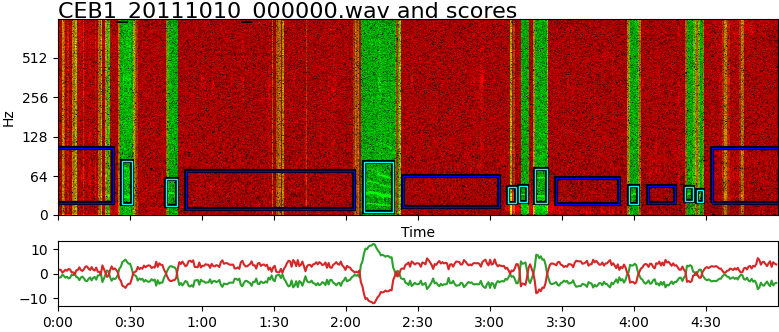

In [36]:
if True:
    audio_file = 'CEB1_20111010_000000.wav'
    labels = raven_file_helper.get_all_labels_for_wav_file(audio_file)
    negative_labels = raven_file_helper.get_negative_labels(labels)
    start_time = 0
    duration=60*5
    embs = get_aves_embeddings_from_file_with_buffers(audio_file,start_time, duration,100,30,sr=AVES_SR).to('cpu')
    with torch.inference_mode():
        scores = my_classifier.forward(embs)

    #visualization_helper.visualize_similarity_on_spectrogams(
    ##    audio_file, start_time,duration,similarity,
    #    dissimilarity,sr=500,n_fft=512,modelname="AVES_base_model")
    
    audio_file_visualizer.visualize_audio_file_fragment(
        f"{audio_file} and scores",
        '/tmp/model_output.png',
        audio_path,
        scores[:,1],
        scores[:,0],
        audio_file_processor,
        start_time=0,
        end_time=duration,
        colormap='clean',
        width=8,
        height=3.5,
        labels = labels,
        negative_labels=negative_labels
    )
    ipd.display(Image.open('/tmp/model_output.png'))

## Validate it against a test dataset

In [23]:
import numpy as np
from sklearn.metrics import f1_score
import sklearn.metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [24]:

def get_predictions(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    all_outputs = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels), np.array(all_outputs)


#plot_confusion_matrix(y_true, y_pred, ['R','N'])


In [25]:


testing_loader  = DataLoader(testing_dataset, batch_size=1000, shuffle=False, num_workers=0)


best_classifier = eri.ElephantRumbleClassifier()
best_model_name = "elephant_rumble_classifier_500_192_2024-06-29T23:39:01.415771_valloss=5.83.pth"
best_classifier.load_pretrained_weights(best_model_name)
best_pred,best_true,best_scores = get_predictions(best_classifier, testing_loader, 'cpu')

this_pred,this_true,this_scores = get_predictions(my_classifier, testing_loader, 'cpu')

print(best_true[0:100].tolist())
print(best_pred[0:100].tolist())
print(this_pred[0:100].tolist())



[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1]
[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0]


In [26]:
# Try this model
 
from sklearn.metrics import classification_report
target_names = ['not','rum']
print(classification_report(this_true, this_pred, target_names=target_names))

              precision    recall  f1-score   support

         not       0.96      0.92      0.94     66252
         rum       0.93      0.97      0.94     66252

    accuracy                           0.94    132504
   macro avg       0.94      0.94      0.94    132504
weighted avg       0.94      0.94      0.94    132504



In [27]:
# Compare with the best model from the past

from sklearn.metrics import classification_report
target_names = ['not','rum']
print(classification_report(best_true, best_pred, target_names=target_names))

              precision    recall  f1-score   support

         not       0.97      0.92      0.94     66252
         rum       0.92      0.97      0.94     66252

    accuracy                           0.94    132504
   macro avg       0.94      0.94      0.94    132504
weighted avg       0.94      0.94      0.94    132504



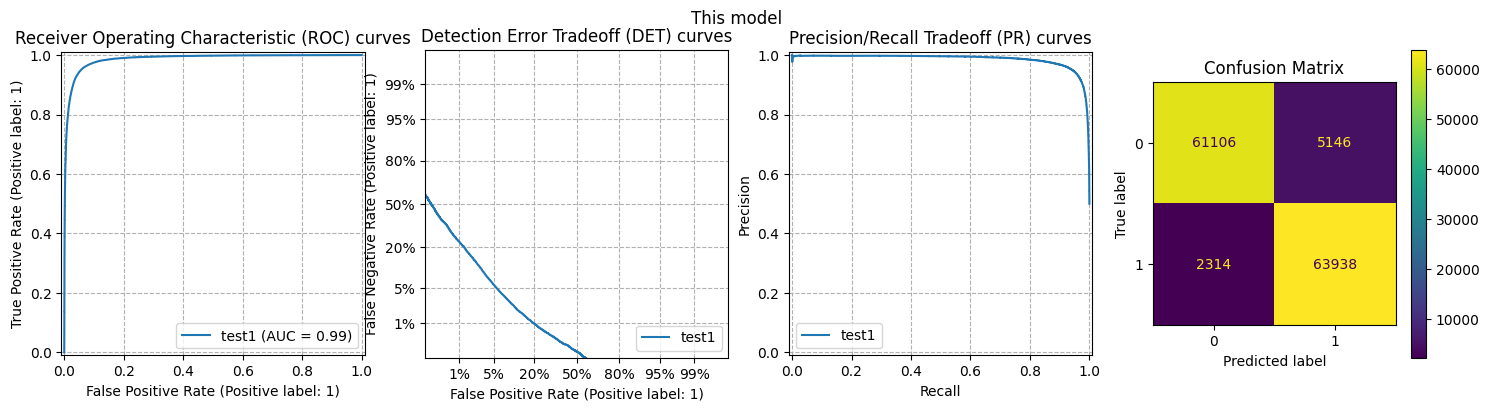

In [28]:

def show_metrics(y_test, y_pred, scores, title):

  fig, [ax_roc, ax_det, ax_prd, ax_con] = plt.subplots(1, 4, figsize=(18, 4))

  RocCurveDisplay.from_predictions(y_test, scores, ax=ax_roc, name="test1")
  DetCurveDisplay.from_predictions(y_test, scores, ax=ax_det, name="test1")

  prec, recall, _ = precision_recall_curve(y_test, scores, pos_label=1)
  pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
  pr_display.plot(ax=ax_prd, name="test1")

  ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
  ax_det.set_title("Detection Error Tradeoff (DET) curves")
  ax_prd.set_title("Precision/Recall Tradeoff (PR) curves")
  ax_con.set_title("Confusion Matrix")

  cm = confusion_matrix(y_test, y_pred)
  cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax_con)

  for ax in [ax_roc, ax_det, ax_prd]:
      ax.grid(linestyle="--")
  fig.suptitle(title)

  plt.show()

show_metrics(this_true, this_pred, this_scores[:,1], "This model")

##

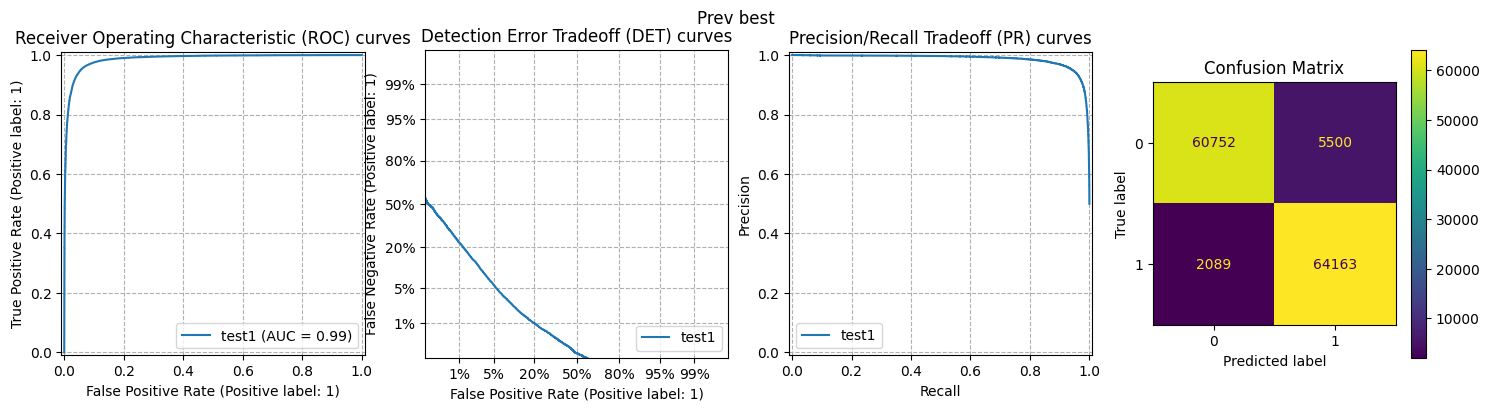

In [29]:
show_metrics(best_true, best_pred, best_scores[:,1], "Prev best")

## Deprecated Training Notes.

Airplanes are very distracting to this model.

Each of these sections have airplanes with false positives and false negatives.

        '/home/ron/proj/elephantlistening/tmp/aves/2024-07-07.train/madj_20150212_000000.wav_20:25:00.png'
        '/home/ron/proj/elephantlistening/tmp/aves/2024-07-07.train/jobo_20160507_000000.wav_23:05:00.png'
        '/home/ron/proj/elephantlistening/tmp/aves/2024-07-07.train/CEB1_20150807_000000.wav_14:00:00.png'
        '/home/ron/proj/elephantlistening/tmp/aves/2024-07-07.train/CEB1_20120727_000000.wav_17:25:00.png'
        '/home/ron/proj/elephantlistening/tmp/aves/2024-07-07.train/CEB1_20111210_000000.wav_23:05:00.png'
        '/home/ron/proj/elephantlistening/tmp/aves/2024-07-07.train/CEB1_20111210_000000.wav_02:00:00.png'
        '/home/ron/proj/elephantlistening/tmp/aves/2024-07-07.train/CEB1_20111210_000000.wav_08:40:00.png'
        '/home/ron/proj/elephantlistening/tmp/aves/2024-07-07.train/CEB1_20111210_000000.wav_01:55:00.png'
        '/home/ron/proj/elephantlistening/tmp/aves/2024-07-07.train/CEB1_20111210_000000.wav_20:40:00.png'
        '/home/ron/proj/elephantlistening/tmp/aves/2024-07-07.train/CEB1_20111210_000000.wav_20:20:00.png'
        '/home/ron/proj/elephantlistening/tmp/aves/2024-07-07.train/CEB1_20111203_000000.wav_08:40:00.png'
        '/home/ron/proj/elephantlistening/tmp/aves/2024-07-07.train/CEB1_20111112_000000.wav_08:30:00.png'
        '/home/ron/proj/elephantlistening/tmp/aves/2024-07-07.train/CEB1_20111107_000000.wav_16:55:00.png'
        '/home/ron/proj/elephantlistening/tmp/aves/2024-07-07.train/CEB1_20111107_000000.wav_11:20:00.png'
        '/home/ron/proj/elephantlistening/tmp/aves/2024-07-07.train/CEB1_20111107_000000.wav_21:20:00.png'
        '/home/ron/proj/elephantlistening/tmp/aves/2024-07-07.train/CEB1_20111017_000000.wav_16:30:00.png'
        '/home/ron/proj/elephantlistening/tmp/aves/2024-07-07.train/CEB1_20111017_000000.wav_00:40:00.png'
        '/home/ron/proj/elephantlistening/tmp/aves/2024-07-07.train/CEB1_20111012_000000.wav_22:10:00.png'
        '/home/ron/proj/elephantlistening/tmp/aves/2024-07-07.train/ceb1_20110128_000000.wav_19:45:00.png'
        '/home/ron/proj/elephantlistening/tmp/aves/2024-07-07.train/CEB1_20111010_000000.wav_00:35:00.png'
        '/home/ron/proj/elephantlistening/tmp/aves/2024-07-07.train/CEB1_20111017_000000.wav_18:55:00.png'
        '/home/ron/proj/elephantlistening/tmp/aves/2024-07-07.train/CEB1_20111203_000000.wav_01:05:00.png'


In [ ]:
# #visualization_helper.visualize_similarity_on_spectrogams(audio_file,labels, start_time,duration,similarity,dissimilarity,modelname='simple_2_layer',sr=1000,n_fft=1024)

# #interesting_embs, uninteresting_embs = get_embeddings_for_labels_in_file(audio_file)
# interesting_files = [
# 'nn07b_20191022_000000.wav',
# 'nn07c_20180110_000000.wav',
# 'nn02d_20181022_000000.wav',
# 'CEB1_20111010_000000.wav',
# 'dz_20120201_000000.wav' ,
# 'dz_20120222_000000.wav' ,
# 'nn02d_20181022_000000.wav',
# 'dz_20120222_134648.wav',
# 'nn04a_20200314_000000.wav',
# 'nn03c_20180114_000000.wav', 
# ]
# #interesting_files = raven_file_helper.get_files_with_high_quality_labels()
# #interesting_files = raven_file_helper.get_files_with_low_quality_labels()
# # interesting_files = [
# #   'CEB1_20111010_000000.wav',
# #   'dz_20120222_000000.wav' ,
# # ]
# audio_file = 'nn07b_20191022_000000.wav' # a hard one - lots of background noise
# audio_file = 'nn07c_20180110_000000.wav'
# # audio_file = 'nn02d_20181022_000000.wav' do this one too
# audio_file = 'CEB1_20111010_000000.wav'
# audio_file = 'dz_20120201_000000.wav' 
# audio_file = 'dz_20120222_000000.wav' 
# audio_file = 'nn02d_20181022_000000.wav' # An annoying plane at the very start confuses the classifier
# #audio_file = 'dz_20120222_134648.wav'  # a chance of finding missing ones at around 00:19:00
# audio_file = 'nn04a_20200314_000000.wav'  # chance for finding missing one around 07:04:30 
# audio_file = 'nn03c_20180114_000000.wav' # Totally a rumble at 12:24:45


# ## low_quality_labels classifier is finding ones at 4:30 in spec_nn04a_20200314 !!!!!

# audio_file='CEB1_20111010_000000.wav'  # in this file a plane passes from 35:00 - 39:30
# audio_file = 'dz_20120222_000000.wav'
# audio_file = raven_file_helper.get_files_with_high_quality_labels()[0]


# interesting_embs, uninteresting_embs = get_embeddings_for_labels_in_file(audio_file)


# start_time = 0
# duration = 60 * 60
# labels = raven_file_helper.get_all_labels_for_wav_file(audio_file).fetchall()
# first_interesting_hour = int(labels[0][0]//60//60)
# print(f"the first interesting hour of {audio_file} is {first_interesting_hour}:00:00")
# start_time = 60 * 60 * first_interesting_hour
# first_hour_embs = get_aves_embeddings_from_file_with_buffers(audio_file,start_time, duration,100,30,sr=AVES_SR).to('cpu')
# multi_similarity = first_hour_embs @ interesting_embs.T
# multi_dissimilarity = first_hour_embs @ uninteresting_embs.T

# similarity = einops.reduce(multi_similarity, 'h w -> h', 'max')
# dissimilarity = einops.reduce(multi_dissimilarity, 'h w -> h', 'max')

# visualization_helper.visualize_similarity_on_spectrogams(
#     audio_file, start_time,duration,similarity,
#     dissimilarity,sr=500,n_fft=512,modelname="AVES_base_model")

# important_negative_labels = [
#     ("nn10a_20191006_000000.wav",(16,0,50),(16,1,10), "thunder?"),
#     ("nn10a_20191006_000000.wav",(16,2,35),(16,2,45), "thunder?"),
#     ("nn10a_20191006_000000.wav",(16,14,00),(16,14,20), "thunder?"),
#     ("nn08c_20201005_000100.wav",(19,54,00),(19,54,57), "nn_background_noise"),
#     ("nn08c_20200104_000100.wav",(13,44,00),(13,46,00), "nn_background_noise"),
#     ("nn08c_20200104_000100.wav",(13,10,30),(13,13,30), "nn_background_noise"),
#     ("nn02d_20181022_000000.wav",(0,0,0),(0,30,0),"airplane"),# Note there's an elephant in the middle
#     ("nn02d_20181022_000000.wav",(0,1,40),(3,30,0),"airplane"),# Note there's an elephant in the middle
#     ("CEB1_20111010_000000.wav",(00,36,30),(00,39,30), "airplane"),
#     ("dz_20120222_134648.wav",(0,0,0),(5,0,0),"thunder?"), # but soon after, elephants
#     ("nn06b_20201005_000100.wav",(17,1,30),(17,7,0),"other animal"),  #buffalo?
#     # nn03c_20180114_000000.wav - thunder?
# ]
# important_negative_labels



* Use original Raven files for the positive labels.
* Generate negative labels close-in-time to the positive labels.
* resample all audio files to 1kHz
* save as pytorch float16 audio files
* Pre-compute AVES/Hubert embeddings. 

https://arxiv.org/pdf/2106.07447
```
The convolutional waveform encoder generates a feature
sequence at a 20ms framerate for audio sampled at 16kHz
(CNN encoder down-sampling factor is 320x).
```

* (this model does poorly on nn08c unless more nn* files are added to the training data)
* (false positive on spec_nn03c_20180114 at 27:30 looks like a different kind of animal?)
* (strange sounds in spec_nn06b???? --- good the classifier ignores most of them)
* Found an animal in nn03e_20181015 at 13:53:00 --- buffalo?
* Found an animal in nn01c_20180111 at 05:44:00 --- elephant - it looks similar to the ones later in the same signal
* in nn_06b_20201030_00100.wav_14:00 14ound 14:51:00 it curiously ignores the labeled rumble but hallucinates nearby ones?!
* in dz20120201_0000.wav at 00:18:00 it finds one before the labeled one.
* dz_20120222_000000.wav 00:28:00 totally looks like rumbles


More training notes....

Tried each of these:

```
    number of hidden layers
    hidden_layer_dim = 25 # good
    hidden_layer_dim = 100 # significantly better than 25
    hidden_layer_dim1,hidden_layer_dim2 = 25,25 # Trains much faster than a single layer of 100, but validation curvy is noisy
    hidden_layer_dim1,hidden_layer_dim2 = 100,25 # Overfits like crazy with the Adam optimizer
    hidden_layer_dim1,hidden_layer_dim2 = 25,25 #
    hidden_layer_dim1,hidden_layer_dim2 = 100,2 # Best model yet at Epoch 10 with Adam -- but it quickly overfits
    hidden_layer_dim1,hidden_layer_dim2 = 10,2
    hidden_layer_dim1,hidden_layer_dim2 = 10,10
    hidden_layer_dim1,hidden_layer_dim2 = 50,10 # pretty good up to epoch 14
    hidden_layer_dim1,hidden_layer_dim2 = 100,2 # feels very similar to 50,10
    hidden_layer_dim1,hidden_layer_dim2 = 25,25 # very noisy validation
    hidden_layer_dim1,hidden_layer_dim2 = 81,9  # roughly cube root of input dim  Best around 9 epochs, but blows up badly by epoch 14.
    hidden_layer_dim1,hidden_layer_dim2 = 33,6  # Best validation of all so far at epoch 15.
    hidden_layer_dim1,hidden_layer_dim2 = 100,None  # 1 layer -- best of all at epoch 10
    hidden_layer_dim1,hidden_layer_dim2 = 10,None  # takes forever to train
    hidden_layer_dim1,hidden_layer_dim2 = 20,None  # takes forever to train
    hidden_layer_dim1,hidden_layer_dim2 = input_dim,None  # The second best of all at epoch 7, but quickly overfits.
    hidden_layer_dim1,hidden_layer_dim2 = input_dim//2,None  # The best of all at epoch 8, and slowly overfits
    hidden_layer_dim1,hidden_layer_dim2 = input_dim//4,None  # Getting worse; kinda like 100,None
    hidden_layer_dim1,hidden_layer_dim2 = input_dim*2,None  # Really slow.
    hidden_layer_dim1,hidden_layer_dim2 = 2,None  # very low quality
    hidden_layer_dim1,hidden_layer_dim2 = input_dim//2,None  # best so far - stop at epoch 8 or so with no dropout

    # With: hidden_layer_dim = 25  , output_dim = 2
    LeakyReLU trains much faster than sigmoid. GELU is in between.
    With the larger low quality label dataset, they're still improving after 4 minutes.


    """
     Don't bother with single-layer or 3-layer networks. 
     See tests on Jun 29.
    """
    
    ### class MyNetwork(nn.Module):
    ### def __init__(self):
    ###     super(MyNetwork, self).__init__()
    ###     self.act = nn.LeakyReLU()
    ###     self.linear1 = nn.Linear(input_dim, hidden_layer_dim1)
    ###     self.linear2 = nn.Linear(hidden_layer_dim1, hidden_layer_dim2)
    ###     self.linear3 = nn.Linear(hidden_layer_dim2, output_dim)
    ### def forward(self, x):
    ###     x = self.linear1(x)
    ###     x = self.act(x)
    ###     x = self.linear2(x)
    ###     x = self.act(x)
    ###     x = self.linear3(x)
    ###     return x

    For dropout  
    0.0 dropout = bad overfitting by epoch 9
    0.2 and 0.4 was pretty good applied to just the second layer
    0.1 is too small if only applied on the second layer, near best if applied on both.
    0.3 applied to both makes it converge slowly but with good validation results and never seems to overfit
    0.2 applied to both makes it converge reasonably fast and seems stable through epoch 20
    hidden_layer_dim1 = 24

    hidden_layer_dim1,hidden_layer_dim2 = input_dim//4,None  # best so far - stop at epoch 8 or so with no dropout
    hidden_layer_dim1 = input_dim//8 # with dropout, //8 is as good as //4 on files under Training
    hidden_layer_dim1 = input_dim//4 # performed better on some other test/train splits
```

In [ ]:
# """
#   TODO

#     Do I need to pass past_key_value or key_value_states or hidden_states
#     to the model for streaming?
    
#     * HuggingFace's transformers wave2vec2 seems to make it easy.
#     * TorchAudio's Wave2Vec2Model seems to make it easy.
#     * TorchAudio's wav2vec2_model seems to make it hard :(

#     https://huggingface.co/docs/transformers/en/model_doc/wav2vec2#transformers.modeling_outputs.Wav2Vec2BaseModelOutput
#     >> last_hidden_state ... hidden_states ...

#     https://pytorch.org/audio/main/generated/torchaudio.models.Wav2Vec2Model.html

#     # This guy seems to understand and explain well
#     https://stackoverflow.com/questions/69266293/getting-embeddings-from-wav2vec2-models-in-huggingface



In [ ]:
TODO = """
 We may need to hand-pick some negative labels from hour 7 of nn06b_20201005_00100.wav 
 because overlapping elephant sounds and other animal sounds are causing confusion.

 Also need to hand-pick some negative samples from the low-frequency noise in 
    #audio_file = 'nn03c_20180114_000000.wav'
 around 12:13:30
"""